In [1]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dateutil
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy import stats

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# increase how many characters can be printed per column in jupyter
# pd.set_option('display.max_colwidth', None)

In [2]:
animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

In [3]:
fr_raw = pd.read_csv(r'..\data\search\peak_finder\Final_Results.csv')
fr_raw = fr_raw.drop(fr_raw.filter(regex='Unnamed').columns, axis=1)  # filter out the "Unnamed: " column 
fr_raw.sample(20)

,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),...,20210729_AJ_Toh_RatBloodGlucose_T1101M_20210413_10wk_RBG.raw (F58),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210327_8wk_FBG.raw (F59),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64),20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65),20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66),20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67)
1218,16.335,1758.47925,+,2.052781e+07,NaN,NaN,34,8.699006e+03,9.379971e+03,3.469324e+06,...,4.053947e+06,4.757193e+06,1.302645e+07,4.709154e+06,7.558716e+06,5.063275e+06,1.330339e+07,14188.23696,1.031701e+04,1.026778e+04
919,12.072,842.67767,-,1.078283e+07,NaN,NaN,60,1.269622e+04,1.381278e+04,5.357567e+06,...,6.933926e+06,6.987024e+06,7.353441e+06,7.940030e+06,8.046009e+06,1.053434e+07,8.513023e+06,17257.79843,1.474865e+04,1.398337e+04
1399,18.276,915.77789,+,3.555758e+06,NaN,NaN,2,1.099501e+04,1.204431e+04,1.956342e+06,...,1.342793e+05,1.288744e+06,1.574187e+05,8.967058e+05,2.282496e+05,1.559275e+06,9.737341e+04,13661.54599,1.405820e+04,3.510894e+04
314,6.216,700.55774,+,3.554256e+06,NaN,NaN,2,1.752959e+04,1.101993e+04,5.342357e+04,...,2.416344e+04,1.195488e+06,2.768006e+04,2.098359e+04,4.990348e+04,1.382194e+04,2.253268e+04,13350.56477,1.253603e+04,1.183799e+04
916,12.069,927.68066,-,2.921991e+06,NaN,NaN,58,1.264948e+04,1.376192e+04,1.554481e+06,...,2.495515e+06,2.432587e+06,2.700648e+06,2.220698e+06,2.196826e+06,2.230344e+06,2.198233e+06,17194.26124,1.469435e+04,1.393189e+04
359,7.043,355.07034,+,2.275433e+06,NaN,NaN,2,1.340239e+04,2.964269e+04,2.793307e+04,...,1.907502e+04,3.530307e+04,4.146668e+04,3.380245e+04,3.266829e+04,2.144646e+04,3.286224e+04,86521.36145,1.231243e+04,1.210495e+04
1185,16.004,882.75531,+,5.520981e+06,NaN,NaN,3,1.727409e+04,1.319375e+04,2.940456e+06,...,3.878808e+05,3.005735e+06,5.412753e+05,2.694213e+06,7.824215e+05,2.923465e+06,6.880676e+05,16273.08806,1.527985e+04,1.976706e+04
336,6.644,413.26648,+,2.499685e+06,NaN,NaN,4,5.150102e+05,2.065781e+05,1.438927e+06,...,1.005194e+06,1.183128e+06,6.898325e+05,1.005171e+06,1.105910e+06,9.351183e+05,7.089638e+05,277849.06120,3.352655e+05,1.500855e+05
309,6.084,876.66272,+,3.284508e+06,NaN,NaN,3,2.754251e+04,8.213492e+03,3.782593e+04,...,2.427266e+04,2.512490e+06,1.752019e+04,1.450592e+04,6.862950e+04,2.323426e+04,1.519665e+04,13428.36623,9.193163e+03,8.748282e+03
1020,13.813,943.73761,+,1.842436e+07,NaN,NaN,5,1.037786e+05,1.220312e+05,4.084808e+06,...,3.595772e+06,5.068003e+06,2.819153e+06,5.483855e+06,5.884810e+06,4.585772e+06,3.764618e+06,70102.50781,4.683333e+04,6.369834e+04


### Basic feature engineering:

1. Remove blank and water samples (5 total)

2. Separate into control vs test groups

3. Create 2nd pandas table of metadata compiled from Huishi's metadata info spreadsheet:
    1. "20210421_FBGRBGOGTT_Huishi sample sheet.xlsx"
    2. Include timepoints in pd.datetime format
    3. Include each rat's phenotypes (glucose level, insulin, weight, age, etc.) 
    
4. Explanation of sample metadata:
    1. Rat names: "T1060M", "T1061M", ... "T1102M" (not all number
        1. Not all numbers between 1060 and 1102 are included.
        2. NB: Not all rats had samples submitted for MS lipidomics
        
    2. RBG vs FBG 
        1. RBG = random blood glucose (randomly sampled blood glucose levels)
        2. FBG = fasted blood glucose (collected after fasting at pre-determined time intervals)
        
    3. Age
        1. Date of birth, between 1/23/2021 and 2/1/2021
        2. Metadata from Huishi organized based on "X weeks old" 
            1. Time points: 4, 8, 9, 10, 11, 12 weeks old 
            
     4. Weight
         1. Weights given as around 100, I assume this is grams
         2. Also gives "Weight gain %" or "Weight loss %"
         3. Also includes "Weight (pre-fasting)"
         3. Also includes "4 to 8 weeks" "Weight gain %"
         5. One of the weights has a note "euthanized due to tail injury" and blanks for that rat thereafter
            
     5. Date and time
         1. Given in "When" column
         2. Formats given as "3/26 6pm" or "4/10 10:30am" or "03/29 10:30am" 
      
    10. Other metadata:
        1. Note at top of metadata spreadsheet: "Fasting from 6:30pm to 10:30am; Light cycle 10am to 10pm"
            1. Referring to fasting periods for nile rats, and when the lights were on/off in the room
        2. "Collected hypothalamus, interscapular white fat, interscapular brown fat, inguinal white fat, mesenteric visceral white rat, pancreas, duodenum, jejunum, ileum, liver,"
        3. "Isoflurane 3% with 2L/min oxygen (~2min to go under)"
        4. Under the post-mortem phenotypes: "Used pre-fasting weight to calculate amount of dextrose"


In [28]:
## For easier grouping of files based on RBG vs FBG, analytical order, pairing of samples, and rat label,
## create a dataframe file_grouping that contains all labels and groups per analysis file.
## Columns = rawfile name; lipidex final results filename; order; RBG vs FBG; rat number labels

file_grouping = pd.read_csv(r'..\data\metadata\20210729_AJ_Toh_RatPlasma_Sequence_Exported.csv', skiprows=1)
file_grouping['analytical_run_order'] = range(1, 68)
file_grouping = file_grouping[['File Name', 'analytical_run_order']]

rawfile_cols = fr_raw.filter(regex='.raw').columns

# Dictionary of rawfile names to Lipidex final results file names (which includes (F1), (F2), etc. in column name)
sample_name_to_file_name_map = {}

for file in rawfile_cols.to_list():
    for sfile in file_grouping['File Name'].to_list():
        if sfile in file:
            sample_name_to_file_name_map[sfile] = file

# correlates rawfile name to lipidex final results filename
file_grouping['fr_name'] = file_grouping['File Name'].apply(lambda name: sample_name_to_file_name_map[name] )
    
# Extract the rat label from filename using this horrible chain of str.split() methods 
file_grouping['rat_label'] = file_grouping[file_grouping['File Name'].str.contains('Glucose_T')]['File Name'] \
                                           .str.split('Glucose_T').str[1] \
                                           .str.split('M_2021').str[0] \
                                           .astype('float')

def parse_bg_type(filename):
    if 'RBG' in filename:
        return 'RBG'
    if 'FBG' in filename:
        return 'FBG'

file_grouping['bg_type'] = file_grouping[file_grouping['File Name'].str.contains('RBG|FBG')]['File Name'] \
                                         .apply(parse_bg_type)

# if a file has quant_file == True, then it's one of the 60 runs we will use for data analysis
file_grouping['quant_file'] = ~file_grouping['analytical_run_order'].isin([1,2,3,4,5,6,67])

# extract the week label from filename using chain of str.split()
file_grouping['week'] = file_grouping[file_grouping['File Name'].str.contains('Glucose_T')]['File Name'] \
                                           .str.split('_').str[6] \
                                           .str.split('wk').str[0].astype('float').astype('Int64')

# Extract the lipidex file number from lipidex fr_name 
file_grouping['lipidex_file_number'] = file_grouping['fr_name'].str.extract(r'\(F(.*?)\)').astype('int')

file_grouping['date'] = pd.to_datetime(file_grouping[file_grouping['quant_file'] == True]['File Name'].str.split('_').str[5])

def gluc_tol(rat_label):
    # Original email was wrong, 1091 and 1093 are normal, NOT 1092 and 1093. 
    if rat_label in [1091, 1093]:
        return 'normal'
    elif rat_label in [1076, 1082, 1101]:
        return 'diabetic'
    elif rat_label in [1092, 1060, 1102, 1062, 1074]:
        return 'impaired'
    else:
        return None

file_grouping['glucose_tolerance'] = file_grouping['rat_label'].apply(gluc_tol)

# Include measured blood glucose value (random or fasted) in column 'bg'
bg = obs.loc[(obs['animal'].isin(animals_used)) & (obs['BG type'].isin(['RBG', 'FBG']))]\
       [['animal', 'BG type', 'BG', 'weeks old note']].dropna()
bg['week'] = bg['weeks old note'].str.split(' ').str[0]
bg = bg.drop('weeks old note', axis=1)
bg = bg[(bg['week'] == '8') | (bg['week'] == '9') | (bg['week'] == '10')]  ## Why won't .drop(.isin(['4', '11', '12'])) work???
bg['week'] = bg['week'].astype('int').astype('Int64')
bg['animal'] = bg['animal'].astype('float')
# rename cols so that merge('left') will work to include BG 
bg = bg.rename({'BG type': 'bg_type', 'animal': 'rat_label', 'BG':'bg'}, axis=1)

file_grouping = file_grouping.merge(bg, how='left')

file_grouping.to_csv(r'..\data\metadata\file_grouping.csv', index=False)

file_grouping

,File Name,analytical_run_order,fr_name,rat_label,bg_type,quant_file,week,lipidex_file_number,date,glucose_tolerance,bg
0,20210729_AJ_Toh_RatBloodGlucose_Water_R1,1,20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (...,NaN,NaN,False,<NA>,65,NaT,None,NaN
1,20210729_AJ_Toh_RatBloodGlucose_Water_R2,2,20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (...,NaN,NaN,False,<NA>,66,NaT,None,NaN
2,20210729_AJ_Toh_RatBloodGlucose_Water_R3,3,20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (...,NaN,NaN,False,<NA>,67,NaT,None,NaN
3,20210729_AJ_Toh_RatBloodGlucose_SolventBlank,4,20210729_AJ_Toh_RatBloodGlucose_SolventBlank.r...,NaN,NaN,False,<NA>,2,NaT,None,NaN
4,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank,5,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlan...,NaN,NaN,False,<NA>,1,NaT,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...
62,20210729_AJ_Toh_RatBloodGlucose_T1062M_2021040...,63,20210729_AJ_Toh_RatBloodGlucose_T1062M_2021040...,1062.0,RBG,True,9,14,2021-04-01,impaired,250.5
63,20210729_AJ_Toh_RatBloodGlucose_T1101M_2021033...,64,20210729_AJ_Toh_RatBloodGlucose_T1101M_2021033...,1101.0,RBG,True,8,54,2021-03-30,diabetic,459.5
64,20210729_AJ_Toh_RatBloodGlucose_T1092M_2021033...,65,20210729_AJ_Toh_RatBloodGlucose_T1092M_2021033...,1092.0,RBG,True,8,42,2021-03-30,impaired,76.0
65,20210729_AJ_Toh_RatBloodGlucose_T1092M_2021041...,66,20210729_AJ_Toh_RatBloodGlucose_T1092M_2021041...,1092.0,RBG,True,10,46,2021-04-13,impaired,59.0


### Collaborators included metadata and phenotype data for the nile rats contained in excel sample sheet file:

In [5]:
# obs is the dataframe of observations collected by collaborators. 
# data were originally in a pivoted format, so observations were cleaned into "tidy data format"
obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
# Remove the T and M from T1060M
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)

animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

fr_quant_filenames_in_analytical_order = file_grouping[file_grouping['quant_file'] == True]['fr_name'].to_list()

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]

## Katie raised questions about the trendline of the boxplots in analytical order. Is there an upward trend? Also, what is going on with QC1 being so low? 

### fit a regression line to random features to observe trends 

### the general trend is an upward slope

60
slope:  [0.01614905]
y-intercept:  [18.87730113]


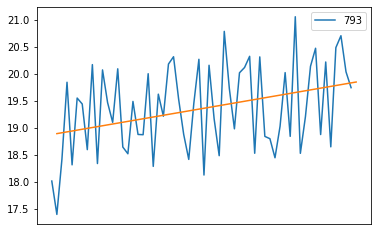

In [6]:
feat = np.log2(fr_raw.sort_values('Area (max)', ascending=False)[fr_quant_filenames_in_analytical_order]
        .filter(regex='RBG|FBG').sample().T)
feat.plot(xticks=[])

print(feat.shape[0])

# print(feat)

# get linear regression of data
fit = np.polyfit(x=range(1,feat.shape[0]+1), y=feat, deg=1)
print('slope: ', fit[0])
print('y-intercept: ', fit[1])

x=np.arange(1, feat.shape[0] + 1, dtype='float64')

plt.plot(x, (fit[0] * x + fit[1]))

plt.show()

### Histogram of slopes of regression lines for individual features is a normal distribution that trends upward. 

Therefore the data will generally trend upward in analytical order. 

array([[   630.59930867],
       [-91634.57298099],
       [ 86371.91623131],
       ...,
       [  3948.81030441],
       [  4458.25298507],
       [  3080.72720451]])

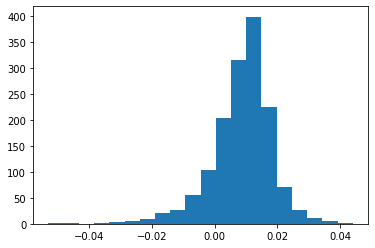

In [7]:
## Calculate all linear regression fits for all features and show histogram of slopes

fit_slopes = []

for index, row in fr_raw[fr_quant_filenames_in_analytical_order].iterrows():
    fit = LinearRegression().fit(np.arange(0,60).reshape(-1, 1),
                                              np.log2(row.T))
    fit_slopes.append(fit.coef_[0])

# print(fit_slopes)
# fit_slopes = np.array(fit_slopes).clip(-1000, 1000)
plt.hist(fit_slopes, bins=20)


from sklearn import linear_model

model = LinearRegression().fit(np.arange(0,60).reshape(-1, 1), 
                                            fr_raw[fr_quant_filenames_in_analytical_order].T)

model.coef_

# plt.plot(np.array(range(0,20)), np.arange(30, 50))

0.00035586527558313256
0.009174943179161165
21.156830311382222
[0.00917494]
0.19885098052896644


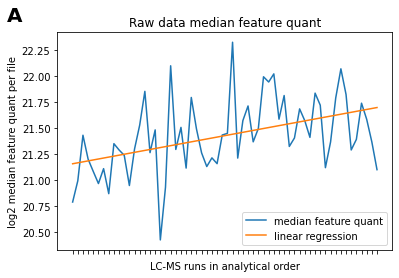

In [57]:
# plots of the medians of each file's quant
file_medians = fr_raw[fr_quant_filenames_in_analytical_order].median(axis=0)

model = LinearRegression().fit(np.arange(0, file_medians.shape[0]).reshape(-1,1),
                                            np.log2(file_medians))

# Using scipy stats module to get p_value easily 
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0, file_medians.shape[0]),
                                                               np.log2(file_medians))
print(p_value)
print(slope)
print(intercept)

print(model.coef_)
print(model.score(np.arange(0, file_medians.shape[0]).reshape(-1,1),
                  np.log2(file_medians)))

fig, ax = plt.subplots()

medians, = ax.plot(np.log2(file_medians))
medians.set_label('median feature quant')
 
fit_line, = ax.plot(np.arange(0,60), (np.arange(0,60) * model.coef_ + model.intercept_))
fit_line.set_label('linear regression')

ax.legend(handles=[medians, fit_line],)

ax.text(-0.15, 1.05, "A", transform=ax.transAxes, fontsize=20, weight='bold')

plt.ylabel('log2 median feature quant per file')
plt.xlabel('LC-MS runs in analytical order')
plt.title('Raw data median feature quant')

# plt.ylim((0, 25))

plt.xticks(list(range(0,60)), ['']*60);

plt.savefig(r'..\reports\collaborator reports\preliminary 20210812\figures\median feature quant raw.png')

In [58]:
normalization_factor_arr = np.arange(0, 60)*slope + intercept 
normalization_factor_arr = (normalization_factor_arr[0] / normalization_factor_arr)
print(normalization_factor_arr)

[1.         0.99956652 0.99913342 0.9987007  0.99826835 0.99783637
 0.99740477 0.99697354 0.99654269 0.9961122  0.99568209 0.99525235
 0.99482298 0.99439398 0.99396535 0.99353709 0.9931092  0.99268167
 0.99225452 0.99182773 0.99140131 0.99097526 0.99054957 0.99012424
 0.98969929 0.98927469 0.98885047 0.9884266  0.9880031  0.98757996
 0.98715718 0.98673477 0.98631271 0.98589102 0.98546969 0.98504871
 0.9846281  0.98420785 0.98378795 0.98336841 0.98294924 0.98253041
 0.98211195 0.98169384 0.98127608 0.98085869 0.98044164 0.98002495
 0.97960862 0.97919264 0.97877701 0.97836174 0.97794681 0.97753224
 0.97711802 0.97670415 0.97629063 0.97587747 0.97546465 0.97505218]


[1.         0.99956652 0.99913342 0.9987007  0.99826835 0.99783637
 0.99740477 0.99697354 0.99654269 0.9961122  0.99568209 0.99525235
 0.99482298 0.99439398 0.99396535 0.99353709 0.9931092  0.99268167
 0.99225452 0.99182773 0.99140131 0.99097526 0.99054957 0.99012424
 0.98969929 0.98927469 0.98885047 0.9884266  0.9880031  0.98757996
 0.98715718 0.98673477 0.98631271 0.98589102 0.98546969 0.98504871
 0.9846281  0.98420785 0.98378795 0.98336841 0.98294924 0.98253041
 0.98211195 0.98169384 0.98127608 0.98085869 0.98044164 0.98002495
 0.97960862 0.97919264 0.97877701 0.97836174 0.97794681 0.97753224
 0.97711802 0.97670415 0.97629063 0.97587747 0.97546465 0.97505218]
new slope after normalization:  3.496506401874729e-05  --> is very close to 0


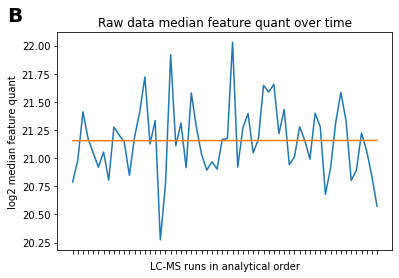

In [59]:
# Multiply each column by a factor that depends on the column index:
# Col 1 is multiplied by 1
# Col 2 multiplied by 0.99
# Col 3 by 0.98 ... 
# Using the slope and intercept from stats.linregress above:

normalization_factor_arr = np.arange(0, 60)*slope + intercept 
normalization_factor_arr = (normalization_factor_arr[0] / normalization_factor_arr)
print(normalization_factor_arr)

fr_norm = np.log2(fr_raw[fr_quant_filenames_in_analytical_order]) * normalization_factor_arr
fr_norm.median(axis=0).plot()

_slope, _intercept, _r_value, _p_value, _std_err = stats.linregress(np.arange(0, file_medians.shape[0]),
                                                                    fr_norm.median(axis=0))

plt.plot(np.arange(0,60), (np.arange(0,60)*_slope + _intercept))

ax = plt.gca()
ax.text(-0.15, 1.05, "B", transform=ax.transAxes, fontsize=20, weight='bold')

print("new slope after normalization: ", _slope, " --> is very close to 0")

plt.ylabel('log2 median feature quant')
plt.xlabel('LC-MS runs in analytical order')
plt.title('Raw data median feature quant over time')

plt.xticks(list(range(0,60)), ['']*60);

plt.savefig(r'..\reports\collaborator reports\preliminary 20210812\figures\median feature quant normalized.png')

0.00035586527558313256
0.009174943179161165
21.156830311382222
[0.00917494]
0.19885098052896644


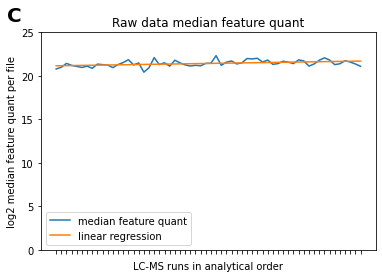

In [56]:
# plots of the medians of each file's quant
file_medians = fr_raw[fr_quant_filenames_in_analytical_order].median(axis=0)

model = LinearRegression().fit(np.arange(0, file_medians.shape[0]).reshape(-1,1),
                                            np.log2(file_medians))

# Using scipy stats module to get p_value easily 
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0, file_medians.shape[0]),
                                                               np.log2(file_medians))
print(p_value)
print(slope)
print(intercept)

print(model.coef_)
print(model.score(np.arange(0, file_medians.shape[0]).reshape(-1,1),
                  np.log2(file_medians)))

fig, ax = plt.subplots()

medians, = ax.plot(np.log2(file_medians))
medians.set_label('median feature quant')
 
fit_line, = ax.plot(np.arange(0,60), (np.arange(0,60) * model.coef_ + model.intercept_))
fit_line.set_label('linear regression')

ax.legend(handles=[medians, fit_line],)

ax.text(-0.1, 1.05, "C", transform=ax.transAxes, fontsize=20, weight='bold')


plt.ylabel('log2 median feature quant per file')
plt.xlabel('LC-MS runs in analytical order')
plt.title('Raw data median feature quant')

plt.ylim((0, 25))

plt.xticks(list(range(0,60)), ['']*60);

plt.savefig(r'..\reports\collaborator reports\preliminary 20210812\figures\median feature quant raw zoomed out.png')

In [12]:
fr_norm = pd.concat([fr_raw.drop(fr_quant_filenames_in_analytical_order, axis=1), (2**fr_norm)], axis=1, ).reindex(fr_raw.columns, axis=1)
fr_norm

,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),...,20210729_AJ_Toh_RatBloodGlucose_T1101M_20210413_10wk_RBG.raw (F58),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210327_8wk_FBG.raw (F59),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64),20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65),20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66),20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67)
0,0.536,679.05463,+,2.408421e+07,NaN,NaN,49,6939.264074,7204.617522,9.974970e+06,...,1.615157e+07,1.210451e+07,1.079174e+07,1.185658e+07,9.721337e+06,9.394720e+06,1.111960e+07,8616.499626,7755.590041,7473.385618
1,0.537,641.10870,+,5.522238e+07,NaN,NaN,36,4957.644286,5147.221739,4.024286e+07,...,3.496832e+07,3.013993e+07,4.966627e+06,3.181116e+07,2.802334e+07,2.191732e+07,2.338934e+07,5992.201567,5261.096948,5307.954232
2,0.541,951.15973,-,3.238113e+07,NaN,NaN,10,31210.491250,6708.897037,1.411587e+07,...,1.431970e+07,1.401550e+07,9.622362e+06,1.533037e+07,1.460625e+07,1.344883e+07,1.259183e+07,9861.409380,94752.403070,72744.082630
3,0.542,329.03067,-,2.882770e+08,NaN,NaN,55,35414.640900,7612.606206,1.100528e+08,...,2.587329e+08,8.100482e+07,1.108561e+08,1.279825e+08,1.603498e+08,1.173300e+08,1.308413e+08,235854.330500,107515.844600,82542.935410
4,0.544,969.13147,-,1.697296e+07,NaN,NaN,14,36157.660320,7772.323038,9.488360e+06,...,6.029466e+06,5.975402e+06,3.492394e+06,8.607944e+06,7.868903e+06,5.873010e+06,7.439766e+06,240802.689200,109771.588600,84274.733400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,20.175,593.58716,+,3.296976e+06,NaN,NaN,19,13463.679470,14827.939600,1.593412e+06,...,2.231748e+05,9.950243e+05,2.409051e+05,6.785744e+05,5.024885e+05,1.198124e+06,1.796502e+05,15946.120300,15354.653040,15239.583030
1483,20.196,871.80945,+,2.595829e+06,NaN,NaN,6,11170.753640,11883.403090,9.364211e+05,...,7.465487e+04,6.616736e+05,7.528183e+04,3.915217e+05,1.006844e+05,7.732758e+05,3.738139e+04,12779.535150,11523.481420,11266.124030
1484,20.435,1003.93829,+,3.203813e+06,NaN,NaN,4,12695.823470,13819.097200,5.219911e+05,...,3.188228e+05,3.064835e+05,6.508379e+05,1.555711e+05,9.012322e+05,3.320783e+05,4.682423e+05,23229.657890,14761.180040,17844.172830
1485,20.452,1164.01404,+,3.204960e+06,NaN,NaN,2,13749.188890,14296.409340,1.536907e+04,...,2.353688e+05,1.696402e+04,5.959354e+05,2.565901e+04,8.628434e+05,2.269965e+04,4.501792e+05,24032.011160,15271.031760,18460.511230


In [27]:
fr_norm.to_csv(r'..\data\processed\lipidomics_linregress_normalized_data.csv', index=False)
fr_norm = pd.read_csv(r'..\data\processed\lipidomics_linregress_normalized_data.csv')
fr_norm

,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),...,20210729_AJ_Toh_RatBloodGlucose_T1101M_20210413_10wk_RBG.raw (F58),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210327_8wk_FBG.raw (F59),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64),20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65),20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66),20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67)
0,0.536,679.05463,+,2.408421e+07,NaN,NaN,49,6939.264074,7204.617522,9.974970e+06,...,1.615157e+07,1.210451e+07,1.079174e+07,1.185658e+07,9.721337e+06,9.394720e+06,1.111960e+07,8616.499626,7755.590041,7473.385618
1,0.537,641.10870,+,5.522238e+07,NaN,NaN,36,4957.644286,5147.221739,4.024286e+07,...,3.496832e+07,3.013993e+07,4.966627e+06,3.181116e+07,2.802334e+07,2.191732e+07,2.338934e+07,5992.201567,5261.096948,5307.954232
2,0.541,951.15973,-,3.238113e+07,NaN,NaN,10,31210.491250,6708.897037,1.411587e+07,...,1.431970e+07,1.401550e+07,9.622362e+06,1.533037e+07,1.460625e+07,1.344883e+07,1.259183e+07,9861.409380,94752.403070,72744.082630
3,0.542,329.03067,-,2.882770e+08,NaN,NaN,55,35414.640900,7612.606206,1.100528e+08,...,2.587329e+08,8.100482e+07,1.108561e+08,1.279825e+08,1.603498e+08,1.173300e+08,1.308413e+08,235854.330500,107515.844600,82542.935410
4,0.544,969.13147,-,1.697296e+07,NaN,NaN,14,36157.660320,7772.323038,9.488360e+06,...,6.029466e+06,5.975402e+06,3.492394e+06,8.607944e+06,7.868903e+06,5.873010e+06,7.439766e+06,240802.689200,109771.588600,84274.733400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,20.175,593.58716,+,3.296976e+06,NaN,NaN,19,13463.679470,14827.939600,1.593412e+06,...,2.231748e+05,9.950243e+05,2.409051e+05,6.785744e+05,5.024885e+05,1.198124e+06,1.796502e+05,15946.120300,15354.653040,15239.583030
1483,20.196,871.80945,+,2.595829e+06,NaN,NaN,6,11170.753640,11883.403090,9.364211e+05,...,7.465487e+04,6.616736e+05,7.528183e+04,3.915217e+05,1.006844e+05,7.732758e+05,3.738139e+04,12779.535150,11523.481420,11266.124030
1484,20.435,1003.93829,+,3.203813e+06,NaN,NaN,4,12695.823470,13819.097200,5.219911e+05,...,3.188228e+05,3.064835e+05,6.508379e+05,1.555711e+05,9.012322e+05,3.320783e+05,4.682423e+05,23229.657890,14761.180040,17844.172830
1485,20.452,1164.01404,+,3.204960e+06,NaN,NaN,2,13749.188890,14296.409340,1.536907e+04,...,2.353688e+05,1.696402e+04,5.959354e+05,2.565901e+04,8.628434e+05,2.269965e+04,4.501792e+05,24032.011160,15271.031760,18460.511230


## Filtering features 

1.  Filter on RSDs of the 2 QCs, using a cutoff of 0.5 (50%)
2.  Add a ‘unique identifier’ label which concatenates RT_quantmz_lipid_id (or unknown)
3.  Add unknown label to ID and class for unknowns
4.  Filter out all features found in 2 or 3 files


In [14]:
fr_norm[fr_norm['Features Found'] < 4]

,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),...,20210729_AJ_Toh_RatBloodGlucose_T1101M_20210413_10wk_RBG.raw (F58),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210327_8wk_FBG.raw (F59),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64),20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65),20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66),20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67)
15,0.594,311.16907,-,8.719601e+06,NaN,NaN,2,1.305713e+06,1.181044e+06,1.228769e+06,...,4.956495e+06,2.436352e+06,4.676546e+06,3.097028e+06,4.654108e+06,2.038349e+06,5.538161e+06,218371.923600,63596.753270,76424.543690
16,0.598,498.29047,-,9.644857e+06,NaN,NaN,2,3.807598e+04,8.607855e+03,1.783426e+06,...,2.814575e+06,1.385029e+06,1.892602e+06,3.514472e+06,2.157975e+06,1.357451e+06,2.907184e+06,262319.529800,119580.190700,91805.072890
18,0.603,339.20020,-,9.878036e+06,NaN,NaN,2,5.921699e+05,7.840420e+05,2.048897e+06,...,2.954306e+06,2.580368e+06,2.962651e+06,1.849654e+06,3.268668e+06,1.359862e+06,3.643032e+06,203695.318800,59322.465620,50584.541940
20,0.610,325.18494,-,1.164583e+07,NaN,NaN,3,1.307049e+06,1.422937e+06,2.410373e+06,...,6.254027e+06,1.557289e+06,6.618708e+06,3.495753e+06,6.682811e+06,2.625556e+06,6.803158e+06,57092.285680,53322.887250,51285.635490
22,0.650,494.96863,+,6.893988e+06,NaN,NaN,3,1.795239e+04,1.305908e+04,1.940360e+06,...,2.323744e+06,9.547430e+05,1.358871e+06,1.298412e+06,1.643692e+06,1.127771e+06,9.913457e+05,6039.728221,5478.861235,5132.901448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475,19.888,857.79486,+,1.489324e+06,NaN,NaN,2,1.200248e+04,1.201948e+04,3.677346e+05,...,1.456614e+04,3.022543e+05,1.492056e+04,1.256692e+05,1.925411e+04,3.984428e+05,1.411384e+04,13476.816120,18857.879890,13362.056820
1476,19.916,1135.98267,+,3.238192e+06,NaN,NaN,2,1.456722e+04,1.458786e+04,6.738326e+04,...,2.226810e+05,2.344357e+04,7.222662e+05,2.815426e+04,9.194577e+05,4.924384e+04,4.199273e+05,18041.993720,22887.516360,16217.321140
1477,19.931,1188.01184,+,2.469986e+06,NaN,NaN,2,1.531678e+04,1.533848e+04,1.814563e+04,...,1.903197e+05,1.684620e+04,6.527016e+05,1.884599e+04,8.464755e+05,1.663990e+04,3.859029e+05,18970.349240,24065.199520,17051.787650
1478,19.956,1161.99829,+,4.962991e+06,NaN,NaN,2,1.810612e+04,1.645047e+04,4.019990e+04,...,4.063366e+05,5.323441e+04,1.045387e+06,5.329917e+04,1.291054e+06,5.703901e+04,6.931085e+05,20332.011240,19083.883900,18275.738300


In [49]:
# drop rows with RSD > 0.5 (50%) as found in QC2 and QC3
# 50% ensures we filter out the reeeally bad features, because we only have 2 good QCs
high_RSD_rows = fr_norm[(fr_norm.filter(regex='QC2|QC3').std(axis=1)/fr_norm.filter(regex='QC2|QC3').mean(axis=1)) > 0.5].index
fr_filt = fr_norm.drop(high_RSD_rows)

fr_filt = fr_filt.drop(fr_filt.filter(regex='Blank|Water|QC1|QC3').columns, axis=1)

# Fill unknowns in Identification and Lipid Class column with 'unknown'
fr_filt['Identification'] = fr_filt['Identification'].fillna('unknown')
fr_filt['Lipid Class'] = fr_filt['Lipid Class'].fillna('unknown')

# Change 'Quant Ion' to dtype 'str' to allow concatenation
fr_filt['Quant Ion'] = fr_filt['Quant Ion'].astype('str')
fr_filt['Retention Time (min)'] = fr_filt['Retention Time (min)'].astype('str')
# Make new unique identifer for each feature
fr_filt['Unique Identifier'] = fr_filt['Identification'] + '_' + \
                                    fr_filt['Quant Ion'] + '_' + fr_filt['Retention Time (min)']
fr_filt['Unique Identifier'] = fr_filt['Unique Identifier'].str.replace(' ', '_')

# Change order to put Unique Identifier column first:
cols_to_order = ['Unique Identifier']
new_columns = cols_to_order + (fr_filt.columns.drop(cols_to_order).tolist())
fr_filt = fr_filt[new_columns]

# rename cols to remove '.raw (F46)'
# cols_to_rename = fr_filt.filter(regex='.raw').columns.to_list()
# fr_filt = fr_filt.rename({col: col.split('.raw')[0] for col in cols_to_rename}, axis='columns')

# drop rows with Features Found in only 2 or 3. 
fr_filt = fr_filt[fr_filt['Features Found'] > 3]

fr_filt.to_csv(r'..\reports\collaborator reports\preliminary 20210812\lipidomics_normalized_filtered_data.csv', index=False)
fr_filt.to_csv(r'..\data\processed\lipidomics_normalized_filtered_data.csv', index=False)

fr_filt

,Unique Identifier,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG.raw (F4),...,20210729_AJ_Toh_RatBloodGlucose_T1101M_20210402_9wk_FBG.raw (F55),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210406_9wk_RBG.raw (F56),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210410_10wk_FBG.raw (F57),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210413_10wk_RBG.raw (F58),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210327_8wk_FBG.raw (F59),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64)
0,unknown_679.05463_0.536,0.536,679.05463,+,2.408421e+07,unknown,unknown,49,9.974970e+06,1.692144e+07,...,1.156896e+07,9.046158e+06,5.364408e+06,1.615157e+07,1.210451e+07,1.079174e+07,1.185658e+07,9.721337e+06,9.394720e+06,1.111960e+07
1,unknown_641.1087_0.537,0.537,641.1087,+,5.522238e+07,unknown,unknown,36,4.024286e+07,5.397037e+07,...,3.207186e+07,2.406236e+07,2.035223e+07,3.496832e+07,3.013993e+07,4.966627e+06,3.181116e+07,2.802334e+07,2.191732e+07,2.338934e+07
2,unknown_951.15973_0.541,0.541,951.15973,-,3.238113e+07,unknown,unknown,10,1.411587e+07,3.166872e+07,...,1.690386e+07,1.185835e+07,1.125893e+07,1.431970e+07,1.401550e+07,9.622362e+06,1.533037e+07,1.460625e+07,1.344883e+07,1.259183e+07
3,unknown_329.03067_0.542,0.542,329.03067,-,2.882770e+08,unknown,unknown,55,1.100528e+08,6.605294e+07,...,1.465332e+08,1.474987e+08,1.043309e+08,2.587329e+08,8.100482e+07,1.108561e+08,1.279825e+08,1.603498e+08,1.173300e+08,1.308413e+08
4,unknown_969.13147_0.544,0.544,969.13147,-,1.697296e+07,unknown,unknown,14,9.488360e+06,1.661334e+07,...,6.829185e+06,7.136770e+06,5.199019e+06,6.029466e+06,5.975402e+06,3.492394e+06,8.607944e+06,7.868903e+06,5.873010e+06,7.439766e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480,unknown_897.82532_20.148,20.148,897.82532,+,3.097802e+06,unknown,unknown,15,1.500998e+06,2.481922e+05,...,8.429923e+05,3.523582e+05,2.826359e+05,2.958877e+05,8.993961e+05,2.819100e+05,6.022171e+05,6.044960e+05,1.120074e+06,1.629972e+05
1481,unknown_974.9118_20.163,20.163,974.9118,+,4.515337e+06,unknown,unknown,4,5.875953e+05,3.533019e+05,...,3.282929e+05,4.255684e+05,1.014151e+05,3.628107e+05,3.027615e+05,4.633196e+05,2.461883e+05,8.729563e+05,4.072792e+05,5.949969e+05
1482,unknown_593.58716_20.175,20.175,593.58716,+,3.296976e+06,unknown,unknown,19,1.593412e+06,1.838481e+05,...,7.550607e+05,2.935374e+05,3.475240e+05,2.231748e+05,9.950243e+05,2.409051e+05,6.785744e+05,5.024885e+05,1.198124e+06,1.796502e+05
1483,unknown_871.80945_20.196,20.196,871.80945,+,2.595829e+06,unknown,unknown,6,9.364211e+05,7.539398e+04,...,4.705706e+05,1.137611e+05,2.433390e+05,7.465487e+04,6.616736e+05,7.528183e+04,3.915217e+05,1.006844e+05,7.732758e+05,3.738139e+04


In [17]:
fr_filt['Unique Identifier'].nunique()

1029

In [ ]:
excel_writer = pd.ExcelWriter(r'..\reports\collaborator reports\preliminary 20210812\24 Aug 2021 Nile rat Lipidomics data.xlsx')

fr_filt.to_excel(excel_writer, sheet_name='Lipidomics normalized filtered', index=False)
fr_norm.to_excel(excel_writer, sheet_name='Lipidomics normalized')
fr_raw.to_excel(excel_writer, sheet_name='Lipidomics raw')

excel_writer.save()
excel_writer.close()

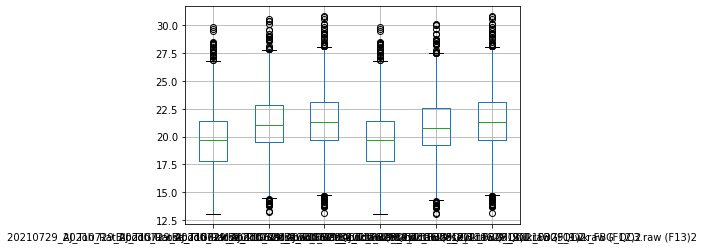

In [18]:
## Comparing pre-normalization raw data QC boxplots vs post-normalization QC boxplots
np.log2(fr_raw.filter(regex='QC')).join(np.log2(fr_norm.filter(regex='QC')), lsuffix='1', rsuffix='2').plot.box()
plt.grid(alpha=1)

<AxesSubplot:>

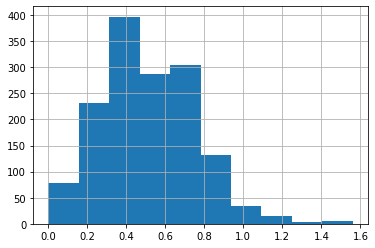

In [19]:
(fr_raw.filter(regex='QC').std(axis=1)/fr_raw.filter(regex='QC').mean(axis=1)).hist()

False    1099
True      388
dtype: int64


<AxesSubplot:>

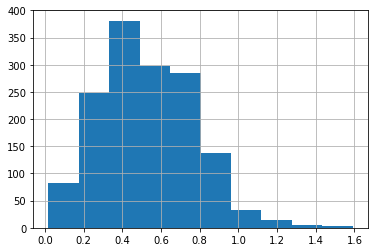

In [20]:
# RSDs of all 3 QCs
all_qc_rsd = fr_norm.filter(regex='QC').std(axis=1)/fr_norm.filter(regex='QC').mean(axis=1)
print((all_qc_rsd > 0.7).value_counts())
all_qc_rsd.hist()

<AxesSubplot:>

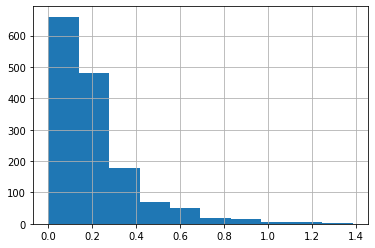

In [21]:
(fr_raw.filter(regex='QC2|QC3').std(axis=1)/fr_raw.filter(regex='QC2|QC3').mean(axis=1)).hist()

False    1302
True      185
dtype: int64


<AxesSubplot:>

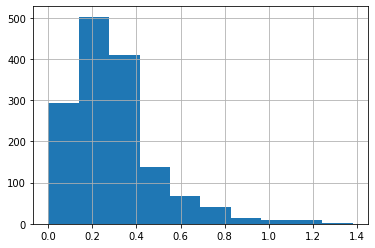

In [22]:
qc2_qc3_rsd = fr_norm.filter(regex='QC2|QC3').std(axis=1)/fr_norm.filter(regex='QC2|QC3').mean(axis=1)
print((qc2_qc3_rsd > 0.5).value_counts())
qc2_qc3_rsd.hist()
